In [3]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import torch
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

### **Loading the Dataset**

In [59]:
torch.manual_seed(27)

In [62]:
trans = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    ),
])

In [63]:
train_dataset = CIFAR10(root='./data',
                        train=True,
                        transform=trans,
                        download=False)

In [64]:
test_dataset = CIFAR10(root='./data',
                       train=False,
                       transform=trans,)

### **Separating the Dataset**

In [65]:
train_size = int(len(train_dataset)*0.9)
val_size = int(len(train_dataset)*0.1)

In [66]:
train_dataset, val_dataset = random_split(dataset=train_dataset, lengths=[train_size, val_size])

### **Creating the DataLoader**

In [67]:
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=64,
                              shuffle=True,
                              num_workers=2, )

In [68]:
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=64,
                             shuffle=False,
                             num_workers=2)

In [69]:
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=64,
                            shuffle=False,
                            num_workers=2)

### **Analysis of Class Distribution**

#### **Train**

In [70]:
train_counter = Counter()

for _, y in train_dataloader:
    train_counter.update(y.tolist())

In [71]:
print("Train label distribution: ", sorted(train_counter.items()))

Train label distribution:  [(0, 4497), (1, 4533), (2, 4528), (3, 4487), (4, 4470), (5, 4454), (6, 4509), (7, 4523), (8, 4511), (9, 4488)]


#### **Test**

In [72]:
test_counter = Counter()

for _, y in test_dataloader:
    test_counter.update(y.tolist())

In [73]:
print("Test label distribution: ", sorted(test_counter.items()))

Test label distribution:  [(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


#### **Val**

In [74]:
val_counter = Counter()

for _, y in val_dataloader:
    val_counter.update(y.tolist())

In [75]:
print("Val label distribution: ", sorted(val_counter.items()))

Val label distribution:  [(0, 503), (1, 467), (2, 472), (3, 513), (4, 530), (5, 546), (6, 491), (7, 477), (8, 489), (9, 512)]


### **Viewing some Data**

In [76]:
for x, _ in train_dataloader:
    break

In [77]:
x.shape

torch.Size([64, 3, 32, 32])

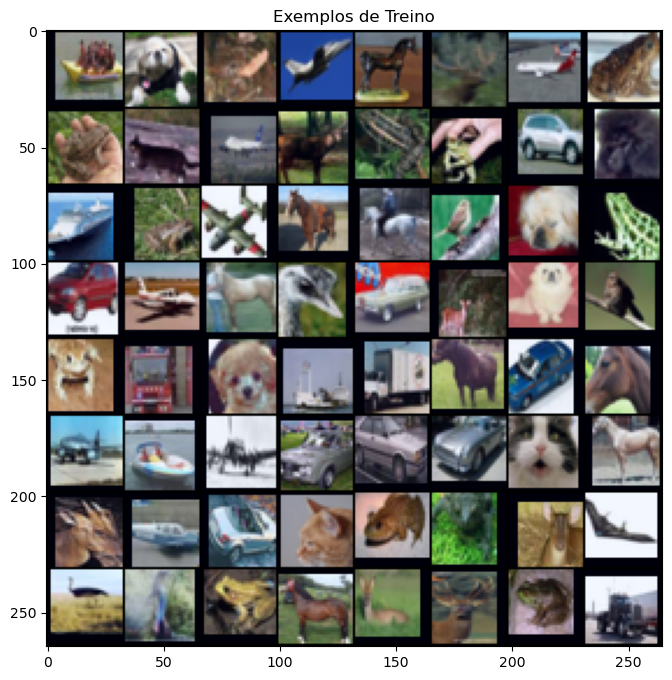

In [78]:
plt.figure(figsize=(8,8))
plt.title('Exemplos de Treino')
plt.imshow(np.transpose(make_grid(x[:64], 
                                  padding=1,
                                  normalize=True,
                                  pad_value=0.0), (1,2,0)))

### **Residual Neural Network**

In [79]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3):
        super().__init__()

        if kernel_size == 3:
            padding = 1
        else:
            padding = 2
        
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride),
                torch.nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)

        return F.relu(out)

In [ ]:
class ResNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv_b1 = torch.nn.Sequential(
            ConvBlock(in_channels=3, out_channels=8, stride=1, kernel_size=3), # 32 x 32
            ConvBlock(in_channels=8, out_channels=8, stride=1, kernel_size=3), # 32 x 32
            ConvBlock(in_channels=8, out_channels=8, stride=1, kernel_size=3), # 32 x 32
            ConvBlock(in_channels=8, out_channels=8, stride=1, kernel_size=5), # 32 x 32
            ConvBlock(in_channels=8, out_channels=8, stride=1, kernel_size=5), # 32 x 32
        )

        self.conv_b2 = torch.nn.Sequential(
            ConvBlock(in_channels=8, out_channels=16, stride=2, kernel_size=3), # 16 x 16
            ConvBlock(in_channels=16, out_channels=16, stride=1, kernel_size=3), # 16 x 16
            ConvBlock(in_channels=16, out_channels=16, stride=1, kernel_size=3), # 16 x 16
            ConvBlock(in_channels=16, out_channels=16, stride=1, kernel_size=5), # 16 x 16
            ConvBlock(in_channels=16, out_channels=16, stride=1, kernel_size=5), # 16 x 16
        )

        self.conv_b3 = torch.nn.Sequential(
            ConvBlock(in_channels=16, out_channels=32, stride=2, kernel_size=3), # 8 x 8
            ConvBlock(in_channels=32, out_channels=32, stride=1, kernel_size=3), # 8 x 8
            ConvBlock(in_channels=32, out_channels=32, stride=1, kernel_size=3), # 8 x 8
            ConvBlock(in_channels=32, out_channels=32, stride=1, kernel_size=5), # 8 x 8
            ConvBlock(in_channels=32, out_channels=32, stride=1, kernel_size=5), # 8 x 8
            torch.nn.Dropout2d(0.1),
        )

        self.conv_b4 = torch.nn.Sequential(
            ConvBlock(in_channels=32, out_channels=64, stride=2, kernel_size=3), # 4 x 4
            ConvBlock(in_channels=64, out_channels=64, stride=1, kernel_size=3), # 4 x 4
            ConvBlock(in_channels=64, out_channels=64, stride=1, kernel_size=3), # 4 x 4
            ConvBlock(in_channels=64, out_channels=64, stride=1, kernel_size=5), # 4 x 4
            ConvBlock(in_channels=64, out_channels=64, stride=1, kernel_size=5), # 4 x 4
        )

        self.fc = torch.nn.Linear(64, num_classes)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1,1))
    
    def forward(self, x):
        out = self.conv_b1(x)
        out = self.conv_b2(out)
        out = self.conv_b3(out)
        out = self.avgpool(self.conv_b4(out))

        return self.fc(torch.flatten(out, start_dim=1))

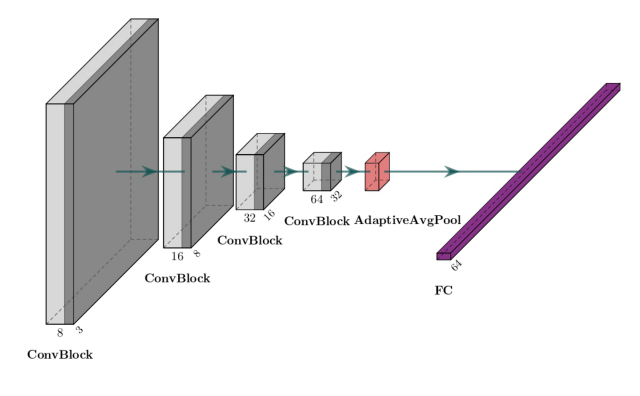

In [12]:
image = Image.open('images/ResNN.jpg')
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(image)

### **Training**

In [81]:
def accuracy(model, dataloader):
    model.eval()

    acc_value = 0.0
    total = 0

    for x, y in dataloader:
        x = x.to('cuda')
        y = y.to('cuda')

        with torch.inference_mode():
            z = model(x)

        labels = torch.argmax(z, dim=1)
        labels = labels.view(y.shape).to(y.dtype)

        results = y == labels
        acc_value += torch.sum(results).item()
        total += torch.numel(results)
    
    return acc_value/total

In [82]:
epochs = 100

In [83]:
model = ResNN(10).to('cuda')
optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)

In [ ]:
best_loss = np.inf
for epoch in range(epochs):
    model.train()

    loss_per_batch = 0.0
    num_batches = len(train_dataloader)
    for idx, (x,y) in enumerate(train_dataloader):
        x = x.to('cuda')
        y = y.to('cuda')

        z = model(x)
        loss = F.cross_entropy(z, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_per_batch += loss.item()

        if idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{epochs} - Batch: {idx+1:03d}/{num_batches} - Loss: {loss:.3f}')
    
    loss_per_batch /= num_batches
    scheduler.step()

    if loss_per_batch < best_loss:
        best_loss = loss_per_batch

        torch.save(model.state_dict(), 'weights.pth')
    
    print(f'Train accuracy: {accuracy(model, train_dataloader)*100:0.2f}% - Val accuracy: {accuracy(model, val_dataloader)*100:0.2f}%')

### **Evaluating the Results**

In [84]:
model.load_state_dict(torch.load('weights.pth', weights_only=True))

<All keys matched successfully>

In [85]:
print(f'Test accuracy: {accuracy(model, test_dataloader)*100}%')

Test accuracy: 86.61%


In [88]:
def show_confusion_matrix(model, dataloader):
    y_pred = []
    y_true = []
    
    model.eval()

    for x, y in dataloader:
        x = x.to('cuda')
        y = y.to('cuda')

        with torch.inference_mode():
            z = model(x)
        
        pred = torch.argmax(z, dim=1)
        pred = pred.view(y.shape).to(y.dtype)

        y_pred.extend(pred.tolist())
        y_true.extend(y.tolist())

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    plt.title('Matriz de Confusão')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

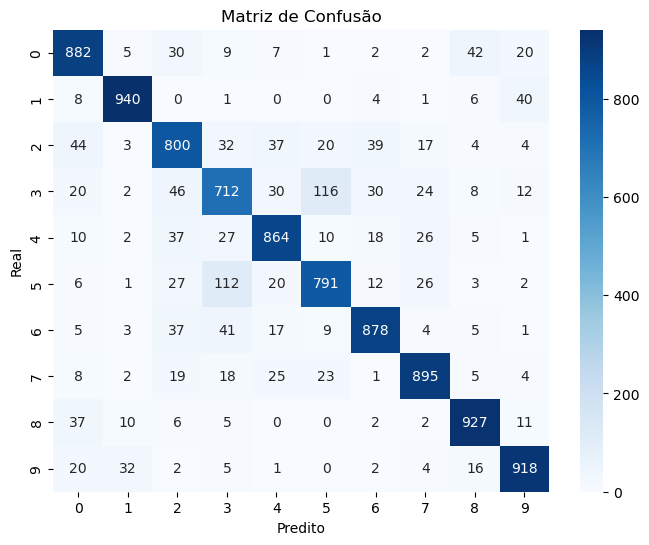

In [89]:
show_confusion_matrix(model, test_dataloader)